# Analisis de datos

## Preparacion de los datos

### Liberias y DFs

In [1]:
#Importar librerias a usar
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import zepid
from zepid.graphics import EffectMeasurePlot
import networkx as nx
from numpy import genfromtxt
from scipy import stats
import os
from IPython.display import Image
from thefuzz import fuzz

c:\Users\someo\AppData\Local\Programs\Python\Python311\Lib\site-packages\thefuzz\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
# Reseteo del directorio principal
os.getcwd()
os.chdir("C:\\Users\someo\Downloads\Review_EDA_Emotion_Recognition")

In [3]:
#Creación de data frames a usar
df_metadata = pd.read_csv('.\data\Tabla Normalizada - Metadata.csv')
df_data_type = pd.read_csv('.\data\Tabla Normalizada - Data type.csv')
df_participants = pd.read_csv('.\data\Tabla Normalizada - Participants.csv')
df_self_report = pd.read_csv('.\data\Tabla Normalizada - Self report.csv')
df_emotion_elicitation_techniques = pd.read_csv('.\data\Tabla Normalizada - Emotion elicitation techniques.csv')
df_eda = pd.read_csv('.\data\Tabla Normalizada - EDA.csv')
df_statistical_learning_models = pd.read_csv('.\data\Tabla Normalizada - Statistical Learning model.csv')
df_performances = pd.read_csv('.\data\Tabla Normalizada - Performances.csv')
df_alg_perf = pd.read_csv('.\data\Tabla Normalizada - Alg_Perf.csv')

### Set características generales de los gráficos
extraido desde: https://towardsdatascience.com/creating-apa-style-plots-in-python-e8adddc3421

In [4]:
plt.rcParams['figure.figsize'] = [20, 10]

matplotlib.style.use(matplotlib.get_data_path()+'/stylelib/apa.mplstyle')

plt.rcParams["legend.fontsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["axes.titlesize"] = 25

### Funciones
* multi_reversing = para casos donde un dato toma mas de valor, o en casos tipicos de one hot encoding (un dato toma un solo valor)
* multi_reversing_n = mismo que el anterior, pero para numeros distintos de cero
* bar_plot = funcion para crear plot de barras
* t_student = test estadistico t de student
* mann_whitney_u = test estadstico U de MannWhitney
* relaciones = utilizada para los grafos, para mostrar la cantidad de veces que aparecieron conexiones entre dimensiones / categorias con n numero de interacciones

In [5]:
def multi_reversing(df,col_id, col_values):
    """la funcion toma nos da la frecuencia de los datos distribuidos en distintas columnas.
    Toma una variable distribuida en varias columnas (one hot encoding), y aplica la funcion melt para cambiar el formato
    de la tabla a long. Luego devuelve una columna donde aparece el nombre de cada columna, la cantidad de veces que fue
    marcada con una 'x' (si accuracy fue marcada 50 veces, aparecera el str 'accuracy' 50 veces, lo que permite graficar su frecuencia
    de aparicion)

    Args:
        df (dataframe): dataframe con el que se desea trabajar, debe poseer las columnas de id_vars y list_value_vars
        in_id_vars (str): nombre de la columna que se usa como identificador de variables 
        value_vars (str o lista): str o lista con el nombre de las columnas de las cuales se desea obtener los datos (se puede
        obviamente subsetear (p.e. dataframe.iloc['columna_1',...,columna_n']))

    Returns:
        dataframe: _description_
    """
    df_raw = pd.melt(df, id_vars = col_id, value_vars = col_values)
    return df_raw[df_raw.value == 'x']

def multi_reversing_n(df,col_id, col_values):
    """exactamente lo mismo que multi_reversing, solo que para casos donde lo que se busca es un numero y no una x
    """
    df_raw = pd.melt(df, id_vars = col_id, value_vars = col_values)
    return df_raw[df_raw.value != 0]

def bar_plot(col, data, titulos):
    var_x = col
    df = data
    g = sns.countplot(x=var_x, data=df, order = getattr(df, var_x).value_counts().index)
    g.set(title = titulos[0], xlabel = titulos[1], ylabel = titulos[2])
    plt.xticks(rotation=90)
    
    plt.tight_layout()
    plt.show()

def t_student(x,y):
	print('Students t-test')
	from scipy.stats import ttest_ind
	stat, p = ttest_ind(x, y, alternative = 'greater')
	print('stat=%.3f, p=%.3f' % (stat, p))
	if p > 0.05:
		print('Probably the same distribution')
	else:
		print('Probably different distributions')


def mann_whitney_u(x,y):
	print('Mann-Whitney U Test')
	from scipy.stats import mannwhitneyu
	stat, p = mannwhitneyu(x, y, alternative = 'greater')
	print('stat=%.3f, p=%.3f' % (stat, p))
	if p > 0.05:
		print('Probably the same distribution')
	else:
		print('Probably different distributions')

def relaciones(weight):
    df_weights_dim = pd.DataFrame(weight)
    wserie = df_weights_dim.value_counts()
    wserie = wserie.to_frame()
    wserie.index.names = ['index']
    wserie.rename(columns = {0:'relations'}, inplace = True)
    wserie = wserie.reset_index()
    
    col1 = wserie.columns[0]
    col2 = wserie.columns[1]

    # iterar sobre las filas del dataframe
    for i, row in wserie.iterrows():
        print(f"Interacciones con {row[col1]} conexiones se observaron {row[col2]/2} veces.")


## Analisis (graficos)

### Mapamundi

In [6]:
df_metadata=df_metadata.fillna('-')
df_metadata_sin_duplicates = df_metadata.drop_duplicates(subset='paper_id')

### ¿Cual es la evolucion temporal (2010-2020) del uso de los modelos emocionales empleados (categoriales o dimensionales)?

Gráfico de barra por año (2010-2020) por paper según modelos de emociones empleado (categoriales o dimensionales)

In [7]:
#rellenar datos faltantes y NO SE DROPEAN los duplicados (hay papers que usan multiples modelos)
df_statistical_learning_models=df_statistical_learning_models.fillna('-')
df_statistical_learning_models=df_statistical_learning_models[df_statistical_learning_models['affective_model'].isin(['categorical', 'dimensional'])]
df_statistical_learning_models_0 = df_statistical_learning_models.groupby(['paper_id','affective_model']).nth(0)
df_statistical_learning_models_0.reset_index(inplace=True)

In [8]:
df_statistical_learning_models_0["year"] = df_statistical_learning_models_0["year"].astype(int)
df_statistical_learning_models_0

,paper_id,affective_model,model_id,apa_citation,year,is_classifier,class_model_output_number,class_model_output_categories,class_Logistic Regression,class_Support Vector Machine (SVM),...,regre_Recurrent NN,regre_LSTM,regre_PNN (probabilistic neural network),model_level_intersubject,model_level_intrasubject,n_model_input,is_physiologicall_interpretation,model_interpretation,is_public_code,public_code_location
0,1,dimensional,1,"Zangróniz, R., Martínez-Rodrigo, A., Pastor, J...",2017,x,2,"calm, distress",-,-,...,-,-,-,x,-,-,-,-,-,-
1,2,categorical,2,"Liu, M., Fan, D., Zhang, X., & Gong, X. (2017)...",2016,x,5,"Happiness, Grief, Fear, Anger, Calm",-,x,...,-,-,-,-,-,-,-,-,-,-
2,3,dimensional,3,"Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...",2018,x,2,"LA, HA",-,-,...,-,-,-,-,-,-,-,-,-,-
3,4,dimensional,5,"Ali, M., Machot, F. A., Mosa, A. H., Jdeed, M....",2018,x,4,"HAHV, HALV, LAHV, LALV",-,-,...,-,-,-,x,-,-,-,-,-,-
4,5,categorical,11,"Wei, J., Chen, T., Liu, G., & Yang, J. (2016)....",2016,-,-,-,-,-,...,-,-,-,-,-,-,x,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,95,dimensional,481,"Yang, H. C., & Lee, C. C. (2019, September). A...",2020,x,2,"HA, LA",-,x,...,-,-,-,-,-,-,x,"Second, our error analysis suggests that\r\nth...",-,-
103,96,dimensional,491,"Kołodziej, M., Tarnowski, P., Majkowski, A., &...",2020,x,2,"HA, LA",-,x,...,-,-,-,-,-,-,x,The best features that were repeated\r\nin the...,-,-
104,97,dimensional,492,"Ganapathy, N., & Swaminathan, R. (2019). Emoti...",2020,x,2,"HA, LA",-,-,...,-,-,-,-,-,-,-,-,-,-
105,98,dimensional,494,"Subramanian, R., Wache, J., Abadi, M. K., Vier...",2018,x,2,"HV, LV",-,x,...,-,-,-,-,-,-,-,-,-,-


### ¿Cual es la evolucion temporal (2010-2020) del uso de los modelos de regresion y categoriales empleados?
Cantidad de modelos de regresion o categorial por anio

2. Hacer un plot de la progresión de modelos de regresión vs clasificación de 2010 a 2020. Este plot deberia ser igual al plot que ve la progresion de modelos dimensioanles vs categoriales. La idea con este plot seria analizar sin la progresion de papers basados en modelos dimensioanels se acompaña con modelso estadísticos de regresion (que es lo que se esperaria dado el tipo de variable, pero asumimos que no sucede)

In [9]:
def label_model (row):
   if row['is_classifier'] == "x" :
      return 'classifier'
   if row['is_regressor'] == "x" :
      return 'regressor'
   return 'Other'

In [10]:
df_statistical_learning_models['model']  = df_statistical_learning_models.apply(lambda row: label_model(row), axis=1)

In [11]:
df_statistical_learning_models['model'].value_counts()

classifier    448
regressor      51
Name: model, dtype: int64

In [12]:
df_models = df_statistical_learning_models[["apa_citation",'model', "year", "model_id"]]

### ¿Cuantas veces fueron testeadas juntas las distintas dimensiones y categorias emocionales?

#### Primero obtenemos las categorias emocionales usadas y su frecuencia

* Hubo 55 modelos que usaron categorias emocionales, siendo disgust, fear, y sadness las mas repetidas.
* Tener en cuenta que un modelo puede usar mas de una categoria, por lo que la funcion get_values no funciona en este caso, y un paper puede concentrar la mayoria de los usos de un conjunto de categorias

In [13]:
df_self_report = df_self_report.fillna('-')

In [14]:
emotional_categories_grouped = df_self_report.groupby(['paper_id','Stress', 'Disgust', 'Fear', 'Sadness', 'Surprise' ,'Happiness', 'Pleasant',
                            'Anxiety', 'Neutral', 'Funny', 'Boredom', 'Relaxation', 'Amusement', 'Joy']).nth(0)
emotional_categories_grouped.reset_index(inplace=True)

In [15]:
emotional_categories_grouped = multi_reversing(
    emotional_categories_grouped, 'paper_id', 
    emotional_categories_grouped
    [[
    'Stress', 'Disgust', 'Fear', 'Sadness', 'Surprise' ,'Happiness', 'Pleasant',
    'Anxiety', 'Neutral', 'Funny', 'Boredom', 'Relaxation', 'Amusement', 'Joy'
    ]])

In [16]:
emotional_categories_grouped

,paper_id,variable,value
74,72,Stress,x
106,4,Disgust,x
112,10,Disgust,x
118,16,Disgust,x
122,20,Disgust,x
...,...,...,...
1376,37,Joy,x
1399,59,Joy,x
1401,60,Joy,x
1410,69,Joy,x


In [17]:
print(emotional_categories_grouped['variable'].value_counts())
print(emotional_categories_grouped['variable'].unique())

Disgust       19
Fear          19
Sadness       19
Neutral       19
Surprise      17
Anxiety       11
Amusement     10
Joy           10
Happiness      8
Boredom        2
Stress         1
Pleasant       1
Funny          1
Relaxation     1
Name: variable, dtype: int64
['Stress' 'Disgust' 'Fear' 'Sadness' 'Surprise' 'Happiness' 'Pleasant'
 'Anxiety' 'Neutral' 'Funny' 'Boredom' 'Relaxation' 'Amusement' 'Joy']


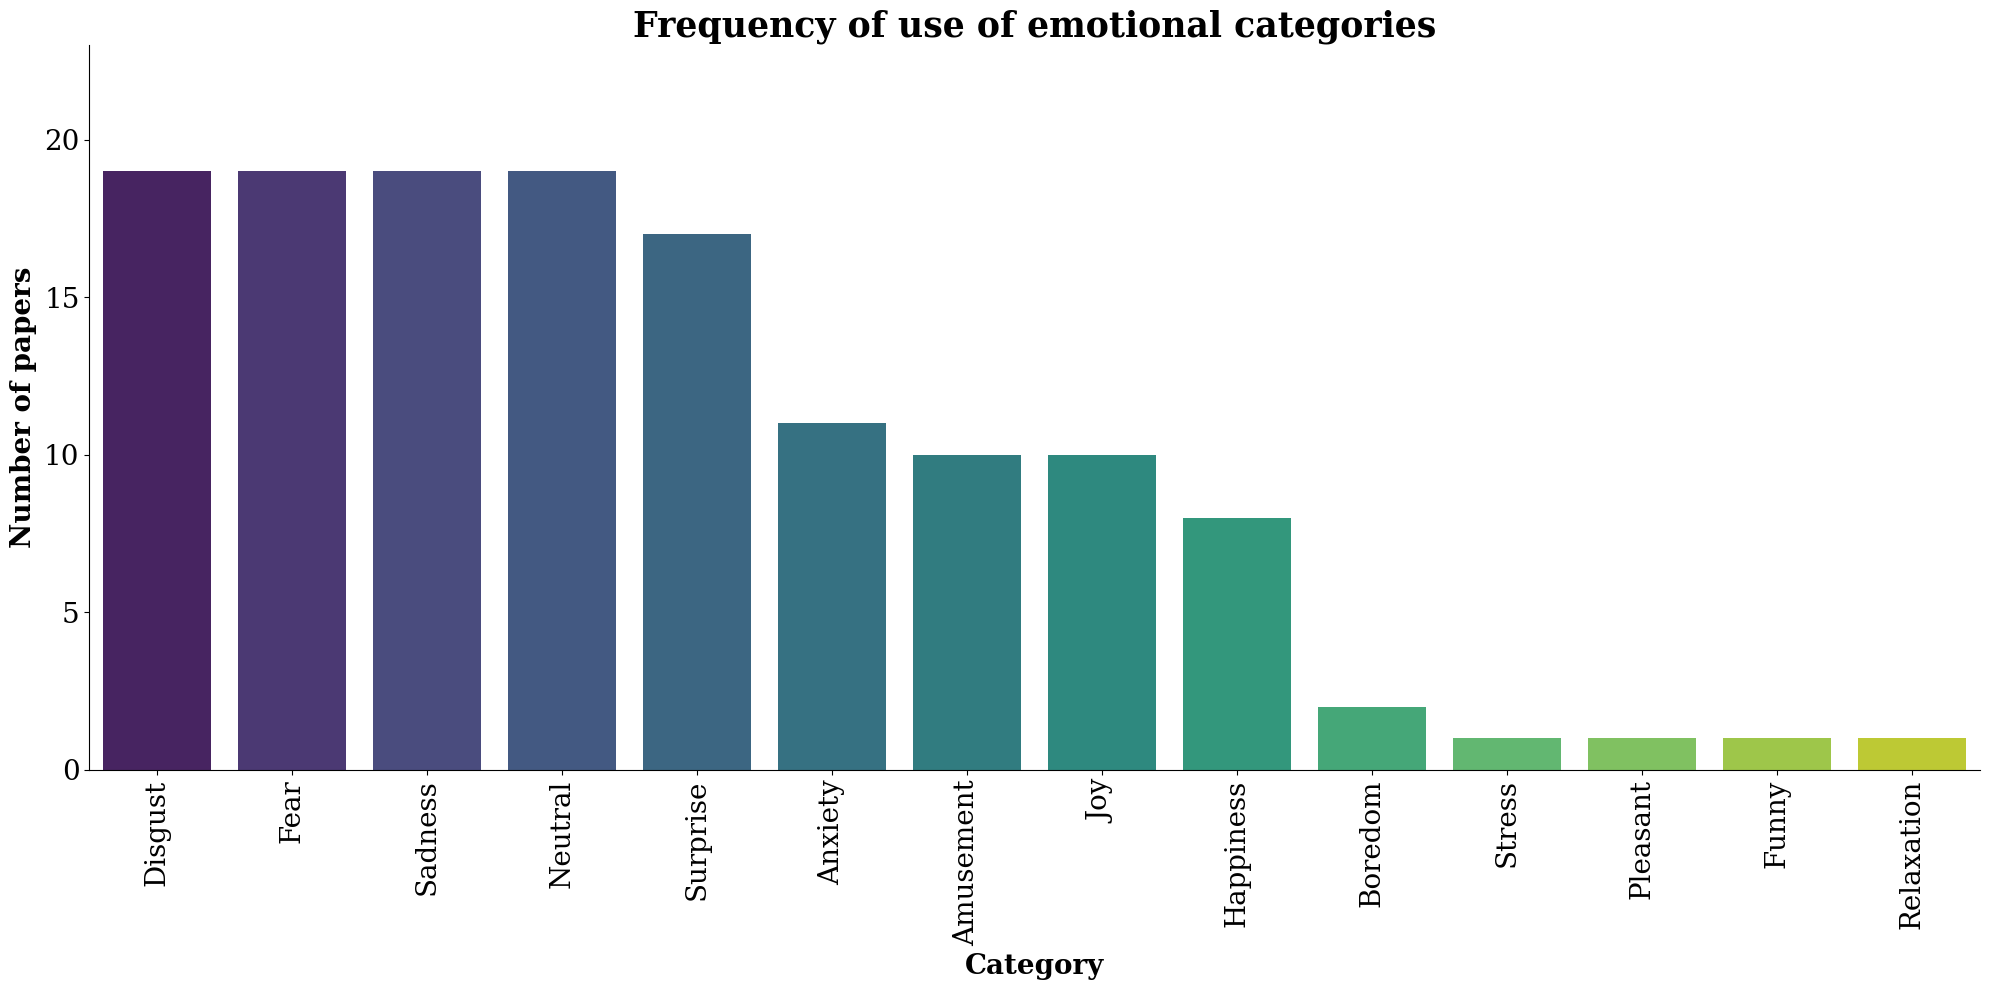

In [18]:
titulos = ['Frequency of use of emotional categories', 'Category', 'Number of papers']

g = sns.countplot(x="variable", data=emotional_categories_grouped, order = getattr(emotional_categories_grouped, "variable").value_counts().index, palette="viridis")
g.set(title = titulos[0], xlabel = titulos[1], ylabel = titulos[2])
plt.xticks(rotation=90)
g.set_ylim([0, 23])
plt.tight_layout()

In [19]:
emotional_dimensions_grouped = df_self_report.groupby([
    'paper_id','valence',
    'arousal', 'dominance', 'like / dislike', 'familiarity', 'engagement',
    'predictability']).nth(0)
emotional_dimensions_grouped.reset_index(inplace=True)

In [20]:
emotional_dimensions_grouped = multi_reversing(
    emotional_dimensions_grouped, 'paper_id', 
    emotional_dimensions_grouped
    [[
    'valence',
    'arousal', 'dominance', 'like / dislike', 'familiarity', 'engagement',
    'predictability'
    ]])

In [21]:
emotional_dimensions_grouped

,paper_id,variable,value
2,3,valence,x
3,4,valence,x
4,5,valence,x
9,10,valence,x
10,11,valence,x
...,...,...,...
658,35,predictability,x
662,37,predictability,x
685,59,predictability,x
686,60,predictability,x


In [22]:
print(emotional_dimensions_grouped['variable'].value_counts())
print(emotional_dimensions_grouped['variable'].unique())

valence           49
arousal           49
dominance         29
like / dislike    20
familiarity       19
predictability     9
engagement         2
Name: variable, dtype: int64
['valence' 'arousal' 'dominance' 'like / dislike' 'familiarity'
 'engagement' 'predictability']


In [23]:
df_models["model"].value_counts()

classifier    448
regressor      51
Name: model, dtype: int64

In [24]:
df_models["model"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

classifier    89.8%
regressor     10.2%
Name: model, dtype: object

#### Creamos el grafo
https://matplotlib.org/stable/tutorials/colors/colormaps.html

In [25]:
#creacion matrix de adyacencia
df_self_report.fillna('-', inplace= True)
self_0 = df_self_report[df_self_report['is_categorial']!= '-']

df_matrix_con_paperid_0 = self_0.groupby(
        ["paper_id",'Anger',
        'Stress', 'Disgust', 'Fear', 'Sadness', 'Surprise', 'Happiness',
        'Pleasant', 'Anxiety', 'Neutral', 'Funny', 'Boredom', 'Relaxation', 'Amusement', 'Joy']
        ).nth(0)
df_matrix_con_paperid_0.reset_index(inplace=True)

print(df_matrix_con_paperid_0)

df_matrix = df_matrix_con_paperid_0[['Anger',
        'Stress', 'Disgust', 'Fear', 'Sadness', 'Surprise', 'Happiness',
        'Pleasant', 'Anxiety', 'Neutral', 'Funny', 'Boredom', 'Relaxation', 'Amusement', 'Joy']
        ]

df_matrix = df_matrix.replace('-', 0)
df_matrix = df_matrix.replace('x', 1)
adj_matrix = df_matrix.T.dot(df_matrix)
np.fill_diagonal(adj_matrix.values, 0)

    paper_id Anger Stress Disgust Fear Sadness Surprise Happiness Pleasant  \
0          4     x      -       x    x       x        x         -        -   
1         10     x      -       x    x       x        x         -        -   
2         16     x      -       x    x       x        x         -        -   
3         20     x      -       x    x       x        x         -        -   
4         32     x      -       x    x       x        x         x        -   
5         35     x      -       x    x       x        x         -        -   
6         37     x      -       x    x       x        x         -        -   
7         37     x      -       x    x       x        x         x        -   
8         43     -      -       -    -       -        -         -        -   
9         59     x      -       x    x       x        x         -        -   
10        60     x      -       x    x       x        x         -        -   
11        61     -      -       -    -       -        -         

In [26]:
adj_matrix

,Anger,Stress,Disgust,Fear,Sadness,Surprise,Happiness,Pleasant,Anxiety,Neutral,Funny,Boredom,Relaxation,Amusement,Joy
Anger,0,0,18,18,18,17,8,0,9,17,0,0,0,10,9
Stress,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Disgust,18,0,0,19,19,17,8,1,10,17,0,0,0,10,9
Fear,18,0,19,0,19,17,8,1,10,17,0,0,0,10,9
Sadness,18,0,19,19,0,17,8,1,10,17,0,0,0,10,9
Surprise,17,0,17,17,17,0,8,0,9,17,0,0,0,9,9
Happiness,8,0,8,8,8,8,0,0,0,8,0,0,0,0,0
Pleasant,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0
Anxiety,9,0,10,10,10,9,0,1,0,9,0,0,0,9,9
Neutral,17,0,17,17,17,17,8,0,9,0,1,0,0,9,9


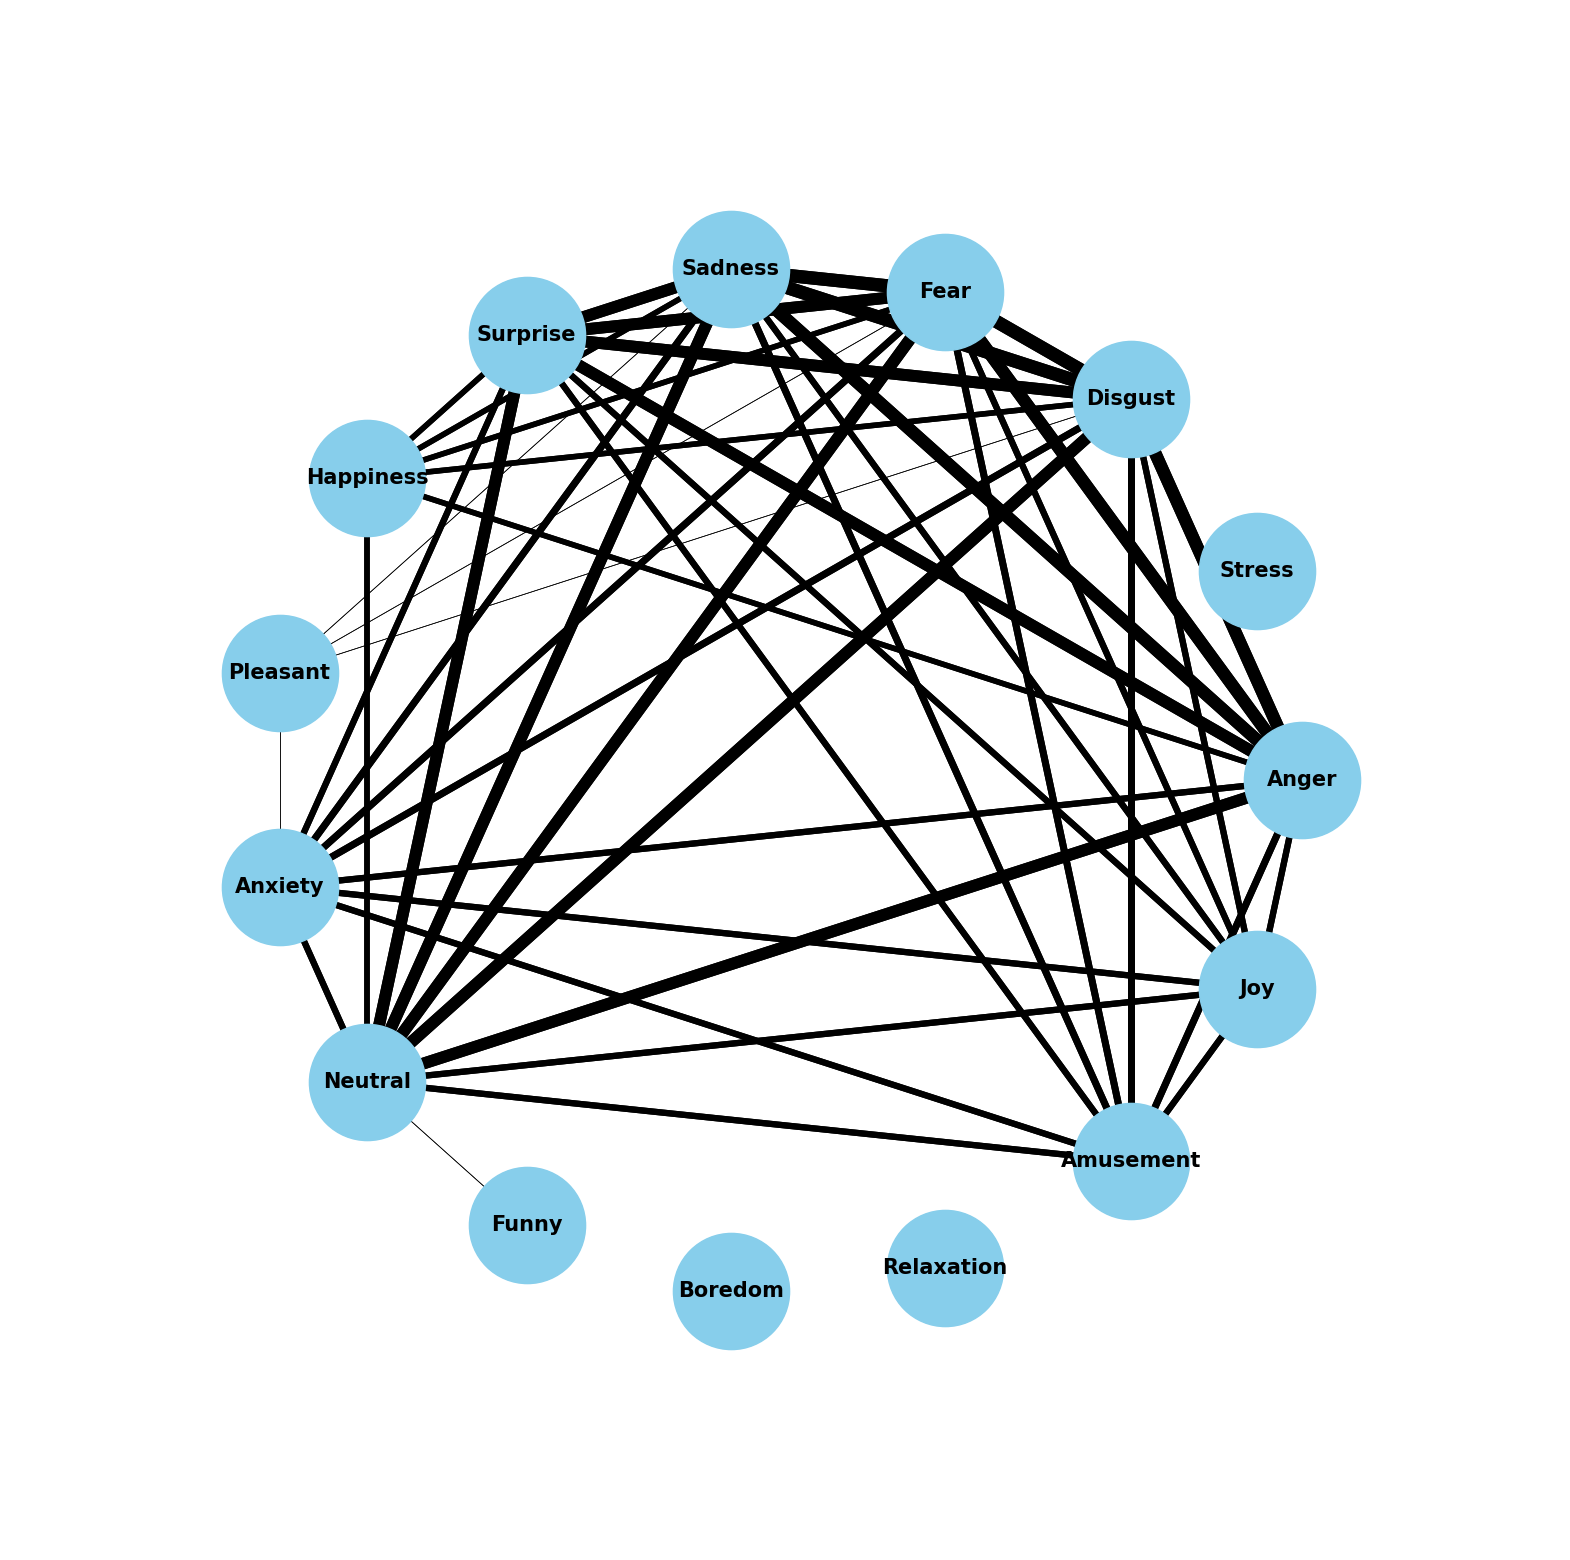

In [27]:
G = nx.DiGraph(adj_matrix)

weights = nx.get_edge_attributes(G,'weight').values()

fig, ax = plt.subplots(figsize=(20, 20))

pos = nx.circular_layout(G)

"""plt.title('Conexiones entre categorias emocionales - Grosor segun numero de relaciones', fontdict = {'fontsize' : 25})"""

nx.draw(G, pos, 
        edge_color="black", 
        node_color='skyblue',
        width=[i/2 for i in weights],
        with_labels=True,
        node_size=7000,
        alpha=1,
        font_size=15,
        font_weight="bold",
        arrows=False,
        edge_cmap=plt.colormaps['copper'])

### ¿Cual es la frecuencia de uso de cada bse de datos encontrada?

6. Gráfico frencuencia de uso de cada base de datos pública encontrada
- Interpretacion: Un predominio de pocas bases de datos. Estamos todo el tiempo sacando conclusiones sobre los mismos sujetos? Ver predominio de bases de datos publicas por sobre las privadas
- No se ha tenido en cuenta el dato aportado por Lorenzo (mas de una db por paper)

In [28]:
df_data_type=df_data_type.fillna('-')
df_data_type_sin_duplicates = df_data_type.drop_duplicates(subset='paper_id')

In [29]:
df_db = df_data_type.groupby(['paper_id',"public_database",'use_multiple_db', 'db_private', 'db_public','db_private_and_public', 'db_uppon_request', 'is_database']).nth(0)
df_db.reset_index(inplace=True)

In [30]:
df_db = multi_reversing(df_db, 'model_id', df_db[["public_database",'use_multiple_db', 'db_private', 'db_public','db_private_and_public', 'db_uppon_request', 'is_database']])
df_db = df_db.replace('Multimodal Dyadic Behavior (MMDB)', 'MMDB')

In [31]:
df_db["variable"].value_counts()

db_private          58
is_database         34
db_public            4
use_multiple_db      2
db_uppon_request     1
Name: variable, dtype: int64

In [32]:
df_data_type["db_access"] = df_data_type["db_access"].str.capitalize()
df_data_type = df_data_type.rename(columns={"db_access":"Access"})

In [33]:
df_data_type[["Access", "model_id", "public_database",'use_multiple_db', 'db_private', 'db_public','db_private_and_public', 'db_uppon_request', 'is_database']]
df_data_type[["public_database",'use_multiple_db', 'db_private', 'db_public','db_private_and_public', 'db_uppon_request', 'is_database']].value_counts()


public_database  use_multiple_db  db_private  db_public  db_private_and_public  db_uppon_request  is_database
-                -                x           -          -                      -                 -              249
                                  -           -          -                      -                 x              128
                 x                -           -          -                      -                 x               62
                 -                -           x          -                      -                 -               49
                                              -          -                      -                 -               10
                                                                                x                 -                1
dtype: int64

In [34]:
df_data_type["Access"].value_counts()

Restricted    259
Open          240
Name: Access, dtype: int64

In [35]:
freq_data_base = df_data_type.groupby(['paper_id', 'DEAP',
       'AMIGOS', 'MAHNOB', 'CASE', 'Ascertain', 'Cog.load',
       'Multimodal Dyadic Behavior (MMDB)', 'RECOLA', 'DECAF',
       'Driving Workload', 'Liris', 'SenseEmotion', 'PMEmo',
       'Hazumi1911', 'Bio Vid Emo DB', 'DREAMER',
       'Non-EEG Biosignals Data Set for Assessment and Visualization of Neurological Status',
       'Stress Recognition in Automobile Drivers Data Set', 'PsPM-HRA1']).nth(0)
freq_data_base.reset_index(inplace=True)

db_freq = multi_reversing(freq_data_base, 'model_id', freq_data_base[['DEAP',
       'AMIGOS', 'MAHNOB', 'CASE', 'Ascertain', 'Cog.load',
       'Multimodal Dyadic Behavior (MMDB)', 'RECOLA', 'DECAF',
       'Driving Workload', 'Liris', 'SenseEmotion', 'PMEmo',
       'Hazumi1911', 'Bio Vid Emo DB', 'DREAMER',
       'Non-EEG Biosignals Data Set for Assessment and Visualization of Neurological Status',
       'Stress Recognition in Automobile Drivers Data Set', 'PsPM-HRA1']])
db_freq['variable'].value_counts()

DEAP                                 10
MAHNOB                                9
AMIGOS                                8
PMEmo                                 3
Ascertain                             2
RECOLA                                2
Cog.load                              1
Multimodal Dyadic Behavior (MMDB)     1
Driving Workload                      1
Liris                                 1
Hazumi1911                            1
Bio Vid Emo DB                        1
Name: variable, dtype: int64

In [36]:
db_freq['variable'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

DEAP                                 25.0%
MAHNOB                               22.5%
AMIGOS                               20.0%
PMEmo                                 7.5%
Ascertain                             5.0%
RECOLA                                5.0%
Cog.load                              2.5%
Multimodal Dyadic Behavior (MMDB)     2.5%
Driving Workload                      2.5%
Liris                                 2.5%
Hazumi1911                            2.5%
Bio Vid Emo DB                        2.5%
Name: variable, dtype: object

In [37]:
db_freq['variable'] = db_freq['variable'].replace(
    to_replace=['Multimodal Dyadic Behavior (MMDB)'], 
    value='MMDB')

In [38]:
df_access = df_data_type[["paper_id","apa_citation",'Access', "year", "model_id"]]

df_access = df_access.groupby(
        ["paper_id",'Access']
        ).nth(0)
df_access.reset_index(inplace=True)

df_access_crosstab = pd.crosstab(index=df_access['year'], columns=df_access['Access'],normalize='index')

C:\Users\someo\AppData\Local\Temp\ipykernel_29512\1899972588.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(ax1.get_yticklabels())
C:\Users\someo\AppData\Local\Temp\ipykernel_29512\1899972588.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(ax2.get_yticklabels())


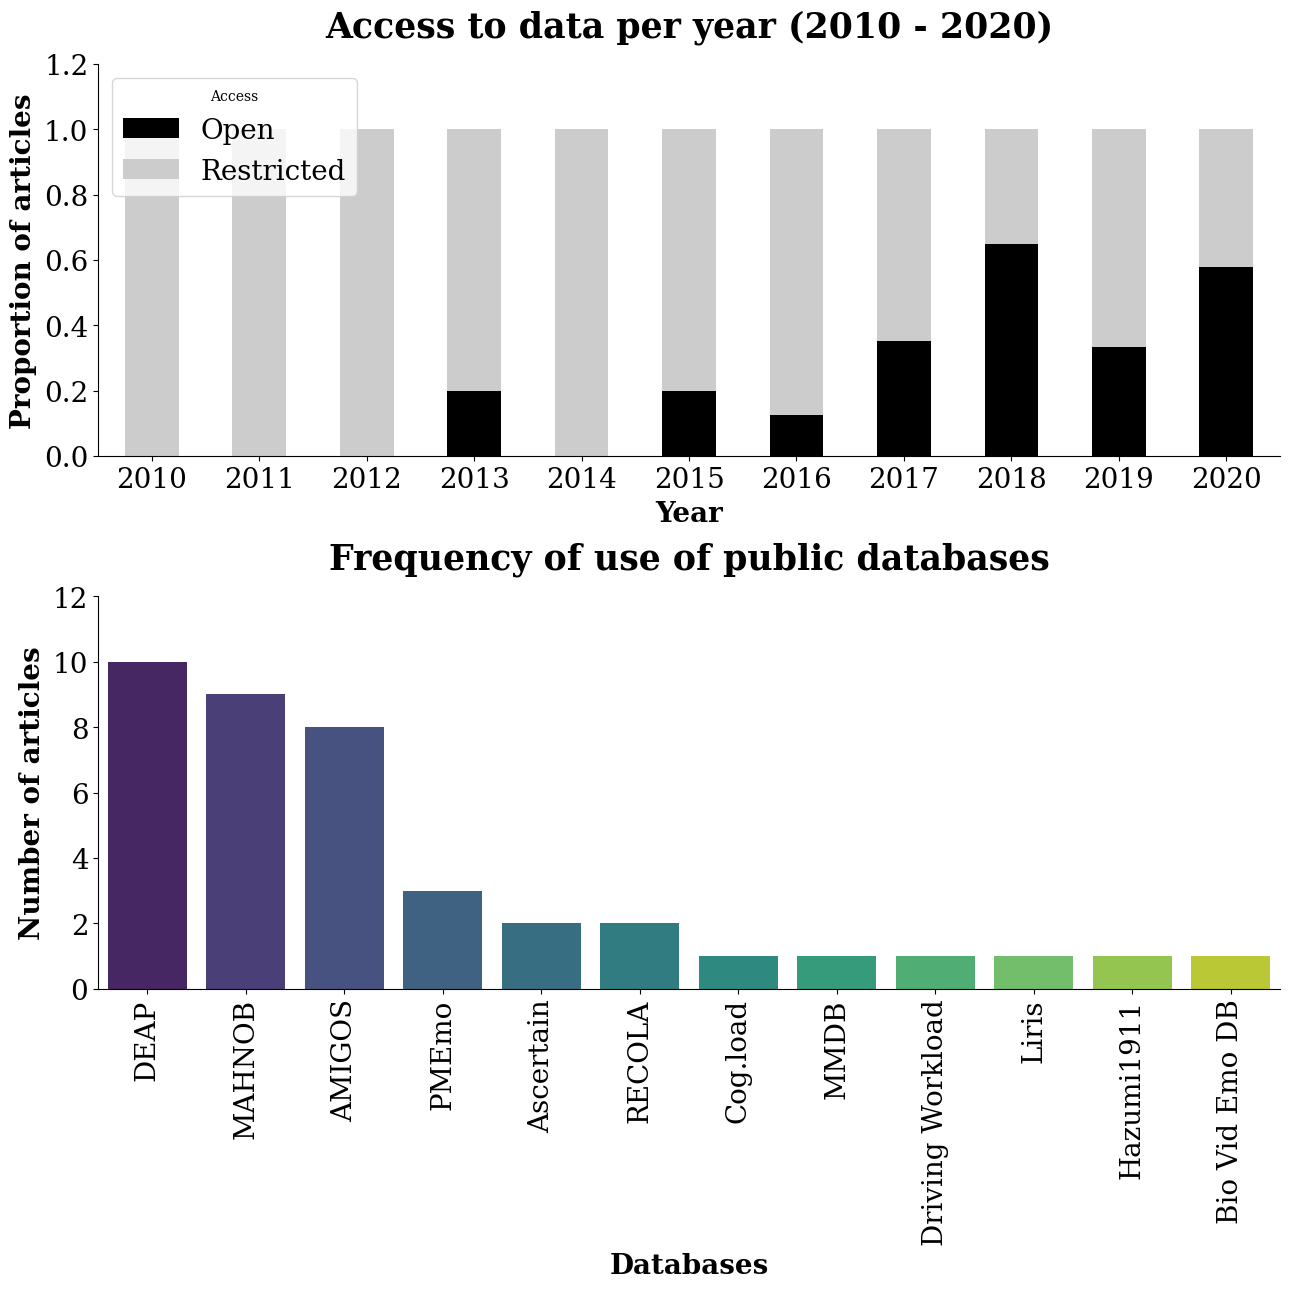

In [39]:
fig, axes = plt.subplots(2, 1)

fig.set_figheight(13)
fig.set_figwidth(13)

ax1 = df_access_crosstab.plot(kind='bar',
                        stacked=True,
                        rot=0,
                        ax=axes[0])


ax2 = sns.countplot(x="variable", 
                    data=db_freq, 
                    order = getattr(db_freq, "variable").value_counts().index, palette="viridis",
                    ax=axes[1])

titulos = ['Frequency of use of public databases', 'Databases', 'Quantity']

ax1.set_yticklabels(ax1.get_yticklabels())
ax2.set_yticklabels(ax2.get_yticklabels())
ax1.set_xticklabels(ax1.get_xticklabels())
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90)

ax1.set_xlabel("Year")
ax1.set_ylabel("Proportion of articles")
ax2.set_xlabel("Databases")
ax2.set_ylabel("Number of articles")

ax1.set_title("Access to data per year (2010 - 2020)",pad=20)
ax2.set_title("Frequency of use of public databases",pad=20)

ax1.legend(title='Access', loc='upper left')

fig.tight_layout()

# Plots para congreso

In [40]:
df_models = df_statistical_learning_models[["paper_id","apa_citation",'model', "year", "model_id"]]

df_models = df_models.groupby(
        ["paper_id",'model']
        ).nth(0)
df_models.reset_index(inplace=True)

In [41]:
df_statistical_learning_models['affective_model'] = df_statistical_learning_models['affective_model'].str.replace('categorical','categorial')

In [42]:
models = df_statistical_learning_models[["paper_id", "year", "affective_model", "model_id"]]

models = models.groupby(
        ["paper_id",'affective_model']
        ).nth(0)
models.reset_index(inplace=True)

models["year"] = models["year"].astype(int)

In [43]:
models["affective_model"].value_counts()

dimensional    68
categorial     39
Name: affective_model, dtype: int64

In [44]:
models_crosstab = pd.crosstab(index=models['year'], columns=models['affective_model'],normalize='index')

In [45]:
"""df_models['model'] = df_models['model'].str.replace('classifier','clasificación')
df_models['model'] = df_models['model'].str.replace('regressor','regresión')"""

"df_models['model'] = df_models['model'].str.replace('classifier','clasificación')\ndf_models['model'] = df_models['model'].str.replace('regressor','regresión')"

In [46]:
n_models = df_models.groupby(
        ["paper_id",'model']
        ).nth(0)
n_models.reset_index(inplace=True)

n_models["year"] = n_models["year"].astype(int)

In [47]:
n_models_crosstab = pd.crosstab(index=n_models['year'], columns=n_models['model'],normalize='index')

C:\Users\someo\AppData\Local\Temp\ipykernel_29512\2505375328.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(ax1.get_yticklabels())
C:\Users\someo\AppData\Local\Temp\ipykernel_29512\2505375328.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(ax2.get_yticklabels())


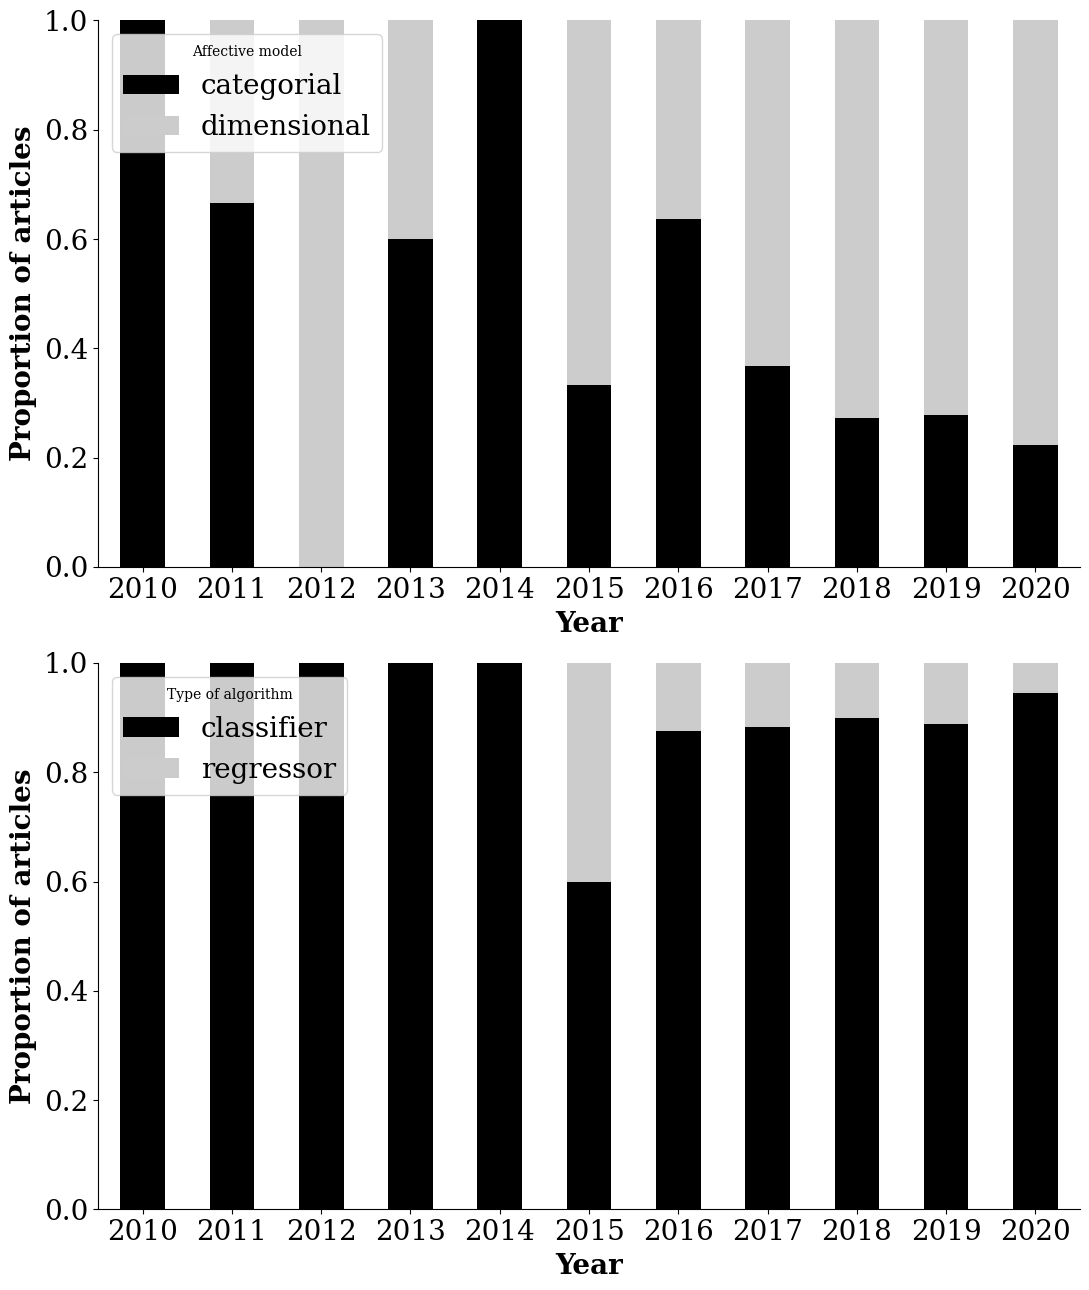

In [48]:
fig, axes = plt.subplots(2, 1, constrained_layout = True)

fig.set_figheight(13)
fig.set_figwidth(11)


ax1 = models_crosstab.plot(kind='bar', 
    stacked=True,
    rot=0,
    ax=axes[0])

ax2 = n_models_crosstab.plot(kind='bar', 
    stacked=True,
    rot=0,
    ax=axes[1])

ax1.set_ylim([0, 1])
ax2.set_ylim([0, 1])

ax1.set_yticklabels(ax1.get_yticklabels())
ax2.set_yticklabels(ax2.get_yticklabels())
ax1.set_xticklabels(ax1.get_xticklabels())
ax2.set_xticklabels(ax2.get_xticklabels())

ax1.set_xlabel("Year")
ax1.set_ylabel("Proportion of articles")
ax2.set_xlabel("Year")
ax2.set_ylabel("Proportion of articles")

"""ax1.set_title("Proportion of articles per year (2010 - 2020) by type of emotional model",pad=20)
ax2.set_title("Proportion of articles per year (2010 - 2020) by type of algorithm",pad=20)"""


ax1.legend(title='Affective model', loc='upper left')
ax2.legend(title='Type of algorithm', loc='upper left')

fig.tight_layout()

C:\Users\someo\AppData\Local\Temp\ipykernel_17848\2925454730.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(ax1.get_yticklabels())
C:\Users\someo\AppData\Local\Temp\ipykernel_17848\2925454730.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(ax2.get_yticklabels())


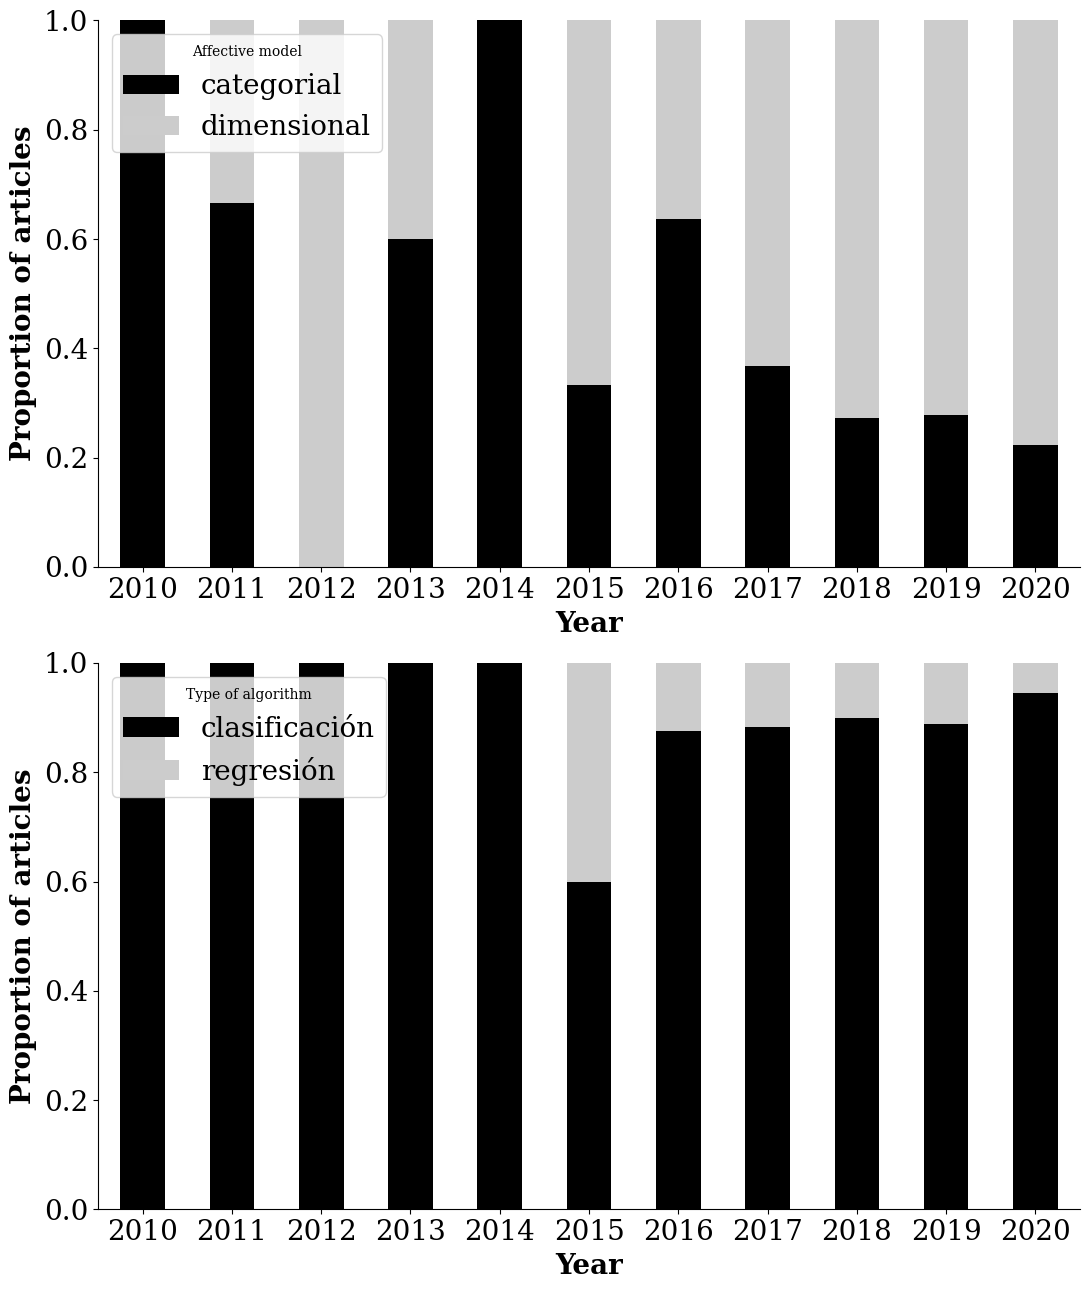

In [49]:
fig, axes = plt.subplots(2, 1, constrained_layout = True)

fig.set_figheight(13)
fig.set_figwidth(11)


ax1 = models_crosstab.plot(kind='bar', 
    stacked=True,
    rot=0,
    ax=axes[0])

ax2 = n_models_crosstab.plot(kind='bar', 
    stacked=True,
    rot=0,
    ax=axes[1])

ax1.set_ylim([0, 1])
ax2.set_ylim([0, 1])

ax1.set_yticklabels(ax1.get_yticklabels())
ax2.set_yticklabels(ax2.get_yticklabels())
ax1.set_xticklabels(ax1.get_xticklabels())
ax2.set_xticklabels(ax2.get_xticklabels())

ax1.set_xlabel("Year")
ax1.set_ylabel("Proportion of articles")
ax2.set_xlabel("Year")
ax2.set_ylabel("Proportion of articles")

ax1.legend(title='Affective model', loc='upper left')
ax2.legend(title='Type of algorithm', loc='upper left')

fig.tight_layout()

### ¿Cual es la evolucion temporal (2010-2020) del uso de los modelos emocionales empleados (categoriales o dimensionales)?

Gráfico de barra por año (2010-2020) por paper según modelos de emociones empleado (categoriales o dimensionales)

### ¿Cual es la performance promedio (usando accuracy) para cada anio?

1. Hacer un plots para ver como cambia la performance promedio (accuracy) en general con el paso del tiempo.  Esto lo resolveria con un box plot por año de accuracy. Donde en el eje X este de 2010 a 2020, y en el eje Y este el accuracy. Con este plot podriamos analizar si efectivamente mejora la performance de los modelos predictivos con el paso del tiempo

In [50]:
#rellenar datos faltantes y NO SE DROPEAN los duplicados (hay papers que usan multiples modelos)
df_statistical_learning_models=df_statistical_learning_models.fillna('-')
df_statistical_learning_models=df_statistical_learning_models[df_statistical_learning_models['affective_model'].isin(['categorical', 'dimensional'])]
df_statistical_learning_models_0 = df_statistical_learning_models.groupby(['paper_id','affective_model']).nth(0)
df_statistical_learning_models_0.reset_index(inplace=True)

In [51]:
df_statistical_learning_models_0["year"] = df_statistical_learning_models_0["year"].astype(int)
df_statistical_learning_models_0

,paper_id,affective_model,model_id,apa_citation,year,is_classifier,class_model_output_number,class_model_output_categories,class_Logistic Regression,class_Support Vector Machine (SVM),...,regre_LSTM,regre_PNN (probabilistic neural network),model_level_intersubject,model_level_intrasubject,n_model_input,is_physiologicall_interpretation,model_interpretation,is_public_code,public_code_location,model
0,1,dimensional,1,"Zangróniz, R., Martínez-Rodrigo, A., Pastor, J...",2017,x,2,"calm, distress",-,-,...,-,-,x,-,-,-,-,-,-,classifier
1,3,dimensional,3,"Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...",2018,x,2,"LA, HA",-,-,...,-,-,-,-,-,-,-,-,-,classifier
2,4,dimensional,5,"Ali, M., Machot, F. A., Mosa, A. H., Jdeed, M....",2018,x,4,"HAHV, HALV, LAHV, LALV",-,-,...,-,-,x,-,-,-,-,-,-,classifier
3,5,dimensional,10,"Wei, J., Chen, T., Liu, G., & Yang, J. (2016)....",2016,-,-,-,-,-,...,-,-,-,-,-,x,"By using the gradient fields (see Fig. 6(c,d))...",-,-,regressor
4,7,dimensional,29,"Schmidt, P., Reiss, A., Duerichen, R., & Van L...",2018,x,2,"stress, not stress",-,-,...,-,-,-,-,-,-,-,-,-,classifier
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,95,dimensional,481,"Yang, H. C., & Lee, C. C. (2019, September). A...",2020,x,2,"HA, LA",-,x,...,-,-,-,-,-,x,"Second, our error analysis suggests that\r\nth...",-,-,classifier
64,96,dimensional,491,"Kołodziej, M., Tarnowski, P., Majkowski, A., &...",2020,x,2,"HA, LA",-,x,...,-,-,-,-,-,x,The best features that were repeated\r\nin the...,-,-,classifier
65,97,dimensional,492,"Ganapathy, N., & Swaminathan, R. (2019). Emoti...",2020,x,2,"HA, LA",-,-,...,-,-,-,-,-,-,-,-,-,classifier
66,98,dimensional,494,"Subramanian, R., Wache, J., Abadi, M. K., Vier...",2018,x,2,"HV, LV",-,x,...,-,-,-,-,-,-,-,-,-,classifier


### ¿Los modelos de clasificacion dimensionales basados en arousal performan mejor que los basados en valence?

Análisis estadístico 
1. Subsetear par quedarse solo con modelso de “HV,LV” (y “LV, “HV”), y “HA,LA” (y “LA, “HA”).
2. FIltrar para quedarnos unicamente con papers que tengan tanto valencia Y arousal (al querer hacer modelos “intrasujeto” es imporatne que se cumpla con esta condición.
3. Agrupar  por paper y sacar la media de la performance (para que quede paper un unico valor de performance promedio de valencia, y un unico valor de performance promedio de arousal. Esto es fundamental para los pasos que siguen)
4. Recien ahora (y  no antes, esto es mucho muy importante) analizar cual es la medida de performance mas prevalente y subsetear para quedarnos solo con esa medida.
5. Hacer T test INTRASUJETO

In [52]:
#creacion data frame y subseteo por: modelos dimensionales, tipo clasiffier, categorias HA/LA y HV/LV
df_alg_perf = df_alg_perf.fillna(0)
df = df_alg_perf
df = df[df['affective_model'] == 'dimensional']
df = df[df['is_classifier'].isin(['x', 'X'])]
df = df[df['class_model_output_categories'].isin(['HA, LA', 'HV, LV', 'LA, HA', 'LV, HV'])]
df[['class_model_output_categories']] = df[['class_model_output_categories']].replace(['LA, HA', 'LV, HV'], ['HA, LA', 'HV, LV' ])

In [53]:
df[["paper_id", "apa_citation", "class_model_output_categories"]]


,paper_id,apa_citation,class_model_output_categories
2,3,"Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...","HA, LA"
3,3,"Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...","HV, LV"
44,11,"Girardi, D., Lanubile, F., & Novielli, N. (201...","HA, LA"
45,11,"Girardi, D., Lanubile, F., & Novielli, N. (201...","HV, LV"
129,20,"Wiem, M. B. H., & Lachiri, Z. (2017). Emotion ...","HA, LA"
...,...,...,...
492,97,"Ganapathy, N., & Swaminathan, R. (2019). Emoti...","HV, LV"
493,98,"Subramanian, R., Wache, J., Abadi, M. K., Vier...","HV, LV"
494,98,"Subramanian, R., Wache, J., Abadi, M. K., Vier...","HV, LV"
495,98,"Subramanian, R., Wache, J., Abadi, M. K., Vier...","HA, LA"


2. FIltrar para quedarnos unicamente con papers que tengan tanto valencia Y arousal (al querer hacer modelos “intrasujeto” es imporatne que se cumpla con esta condición.

In [54]:
"""revision a mano de los modelos
vuela el paper_id 24, 37, 66, 97
porque no contenian modelos tanto para arousal como para valencia
se procede a filtrarlos"""

df.drop(df[ df['paper_id'] == 24].index,inplace = True)
df.drop(df[ df['paper_id'] == 37].index,inplace = True)
df.drop(df[ df['paper_id'] == 66].index,inplace = True)
df.drop(df[ df['paper_id'] == 97].index,inplace = True)

In [55]:
df_excel = df
df_excel.to_excel(".\data\\analisis_estadistico.xlsx")

In [56]:
df.iloc[:,57:]

,accuracy,precision,f-measure,recall-sensitivity-true_positive_rate,specificity_true-negative-rate,false-positive-rate,false-negative-rate,roc-auc,R2,R,MAE-(Mean-Absolute-Error),Concordance-Correlation-Coefficient-(CCC),Spearman’s-ranking-correlation,Mean-square-error-(MSE),Root-Mean-Square-Error-(RMSE),Pearson-Correlation Coefficient-(r),unweighted-average-recall-(UAR),Matthews-Correlation-Coefficient,G-mean-(Geometric-mean)
2,71.53,-,-,-,-,-,0,-,-,0,-,0,0,0,0,0,0,0,0.0
3,71.04,-,-,-,-,0,0,-,-,0,-,0,0,0,0,0,0,0,0.0
44,-,67,63,64,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
45,-,58,35,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
129,62.23,-,-,-,-,-,-,-,-,-,-,-,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,79,78.38,77.85,77.33,77.78,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
493,0,0,64,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
494,0,0,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
495,0,0,61,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0


In [57]:
df[["paper_id", "model_id", "apa_citation", "class_model_output_categories"]]

,paper_id,model_id,apa_citation,class_model_output_categories
2,3,3,"Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...","HA, LA"
3,3,4,"Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...","HV, LV"
44,11,45,"Girardi, D., Lanubile, F., & Novielli, N. (201...","HA, LA"
45,11,46,"Girardi, D., Lanubile, F., & Novielli, N. (201...","HV, LV"
129,20,130,"Wiem, M. B. H., & Lachiri, Z. (2017). Emotion ...","HA, LA"
...,...,...,...,...
490,96,491,"Kołodziej, M., Tarnowski, P., Majkowski, A., &...","HA, LA"
493,98,494,"Subramanian, R., Wache, J., Abadi, M. K., Vier...","HV, LV"
494,98,495,"Subramanian, R., Wache, J., Abadi, M. K., Vier...","HV, LV"
495,98,496,"Subramanian, R., Wache, J., Abadi, M. K., Vier...","HA, LA"


In [58]:
"""
se calcula a mano los promedios de arousal y valencia para cada paper
"""
df2 = pd.read_excel(".\data\\Libro12.xlsx") 
df2.head()

,paper_id,apa_citation,year,affective_model,class_model_output_categories,accuracy,precision,f0measure,recall0sensitivity0true_positive_rate,specificity_true0negative0rate,...,R,MAE0(Mean0Absolute0Error),Concordance0Correlation0Coefficient0(CCC),Spearman’s0ranking0correlation,Mean0square0error0(MSE),Root0Mean0Square0Error0(RMSE),Pearson0Correlation Coefficient0(r),unweighted0average0recall0(UAR),Matthews0Correlation0Coefficient,G0mean0(Geometric0mean)
0,3,"Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...",2018,dimensional,"HA, LA",71.53,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
1,3,"Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...",2018,dimensional,"HV, LV",71.04,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
2,11,"Girardi, D., Lanubile, F., & Novielli, N. (201...",2018,dimensional,"HA, LA",0.00,67.0,63.0,64.0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
3,11,"Girardi, D., Lanubile, F., & Novielli, N. (201...",2018,dimensional,"HV, LV",0.00,58.0,35.0,50.0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
4,20,"Wiem, M. B. H., & Lachiri, Z. (2017). Emotion ...",2017,dimensional,"HA, LA",62.23,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0.0,0.0,0


4. Recien ahora (y  no antes, esto es mucho muy importante) analizar cual es la medida de performance mas prevalente y subsetear para quedarnos solo con esa medida.

In [59]:
df_performance_medidas = multi_reversing_n(df2, 'paper_id',df2.iloc[:,5:])

In [60]:
df2 = df2.fillna('-')
df2 = df2[(df2['accuracy'] != '-') & (df2['accuracy'] != 0)]

In [61]:
#filtramos por accuracy
df2 = df2.fillna('-')
df2 = df2[(df2['accuracy'] != '-') & (df2['accuracy'] != 0)]

In [62]:
df2[["paper_id", "apa_citation", "class_model_output_categories", "accuracy"]]

,paper_id,apa_citation,class_model_output_categories,accuracy
0,3,"Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...","HA, LA",71.53
1,3,"Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...","HV, LV",71.04
4,20,"Wiem, M. B. H., & Lachiri, Z. (2017). Emotion ...","HA, LA",62.23
5,20,"Wiem, M. B. H., & Lachiri, Z. (2017). Emotion ...","HV, LV",55.78
6,23,"Ayata, D., Yaslan, Y., & Kamasak, M. (2017). E...","HA, LA",71.53
7,23,"Ayata, D., Yaslan, Y., & Kamasak, M. (2017). E...","HV, LV",71.04
10,32,"Siddharth, null, Jung, T.-P., & Sejnowski, T....","HA, LA",64.84
11,32,"Siddharth, null, Jung, T.-P., & Sejnowski, T....","HV, LV",63.28
12,38,"Ayata, D., Yaslan, Y., & Kamasak, M. (2017). E...","HA, LA",50.54
13,38,"Ayata, D., Yaslan, Y., & Kamasak, M. (2017). E...","HV, LV",65.33


In [63]:
#creamos df para el analisis estadistico
df_3 = df2[["class_model_output_categories","accuracy"]]
df_3

,class_model_output_categories,accuracy
0,"HA, LA",71.53
1,"HV, LV",71.04
4,"HA, LA",62.23
5,"HV, LV",55.78
6,"HA, LA",71.53
7,"HV, LV",71.04
10,"HA, LA",64.84
11,"HV, LV",63.28
12,"HA, LA",50.54
13,"HV, LV",65.33


Aplicamos los estadísticos

obtenido de: https://machinelearningmastery.com/statistical-hypothesis-tests-in-python-cheat-sheet/

In [64]:
#creacion lista con la performance para arousal y valence
df_arousal = df_3[df_3['class_model_output_categories'] == 'HA, LA']
df_arousal = df_arousal['accuracy']
arousal1 = df_arousal.values.tolist()
arousal1 = list(map(float, arousal1))

df_valence = df_3[df_3['class_model_output_categories'] == 'HV, LV']
df_valence = df_valence['accuracy']
valence1 = df_valence.values.tolist()
valence1 = list(map(float, valence1))

p1 = stats.ttest_rel(arousal1, valence1, alternative = "greater")

print(p1)

#Test parametrico - t de student
#t_student(arousal1, valence1)

#Test no parametrico - U de Mann-Whitney
#mann_whitney_u(arousal1, valence1)

Ttest_relResult(statistic=0.35229084656919984, pvalue=0.3653649152631109)


### ¿Cual es la performance promedio (usando accuracy) para cada anio?

1. Hacer un plots para ver como cambia la performance promedio (accuracy) en general con el paso del tiempo.  Esto lo resolveria con un box plot por año de accuracy. Donde en el eje X este de 2010 a 2020, y en el eje Y este el accuracy. Con este plot podriamos analizar si efectivamente mejora la performance de los modelos predictivos con el paso del tiempo

creacion df para el plot, con el anio las dimensiones y a performance

In [65]:
performances_av = df2[["year", "class_model_output_categories", "accuracy"]]
#reemplazos
performances_av[['class_model_output_categories']] = performances_av[['class_model_output_categories']].replace(['HA, LA', 'HV, LV' ], ['arousal', 'valence' ])
performances_av.rename(columns = {'class_model_output_categories':'dimension', 'accuracy':'performance'}, inplace = True)

performances_av

C:\Users\someo\AppData\Local\Temp\ipykernel_17848\1501514481.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  performances_av[['class_model_output_categories']] = performances_av[['class_model_output_categories']].replace(['HA, LA', 'HV, LV' ], ['arousal', 'valence' ])
C:\Users\someo\AppData\Local\Temp\ipykernel_17848\1501514481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  performances_av.rename(columns = {'class_model_output_categories':'dimension', 'accuracy':'performance'}, inplace = True)


,year,dimension,performance
0,2018,arousal,71.53
1,2018,valence,71.04
4,2017,arousal,62.23
5,2017,valence,55.78
6,2017,arousal,71.53
7,2017,valence,71.04
10,2018,arousal,64.84
11,2018,valence,63.28
12,2017,arousal,50.54
13,2017,valence,65.33


1.bis. subsjetear esta progresion de accuracies pero por dimension afectiva: hacer un plot (conjunto de boxplots de 2010 a 2020) de valencia y otro plot (conjunto de boxplots de 2010 a 2020) de arousal. Este plot nos ayudaría a ver si cambia la progresion de accuracies dependiendo cada dimension afectiva

In [66]:
performances_av=performances_av.rename(columns = {'dimension':'Dimension'})
performances_av=performances_av.rename(columns = {'performance':'Accuracy (%)'})

[Text(0.5, 1.0, 'Performance comparison between arousal and valence-based models')]

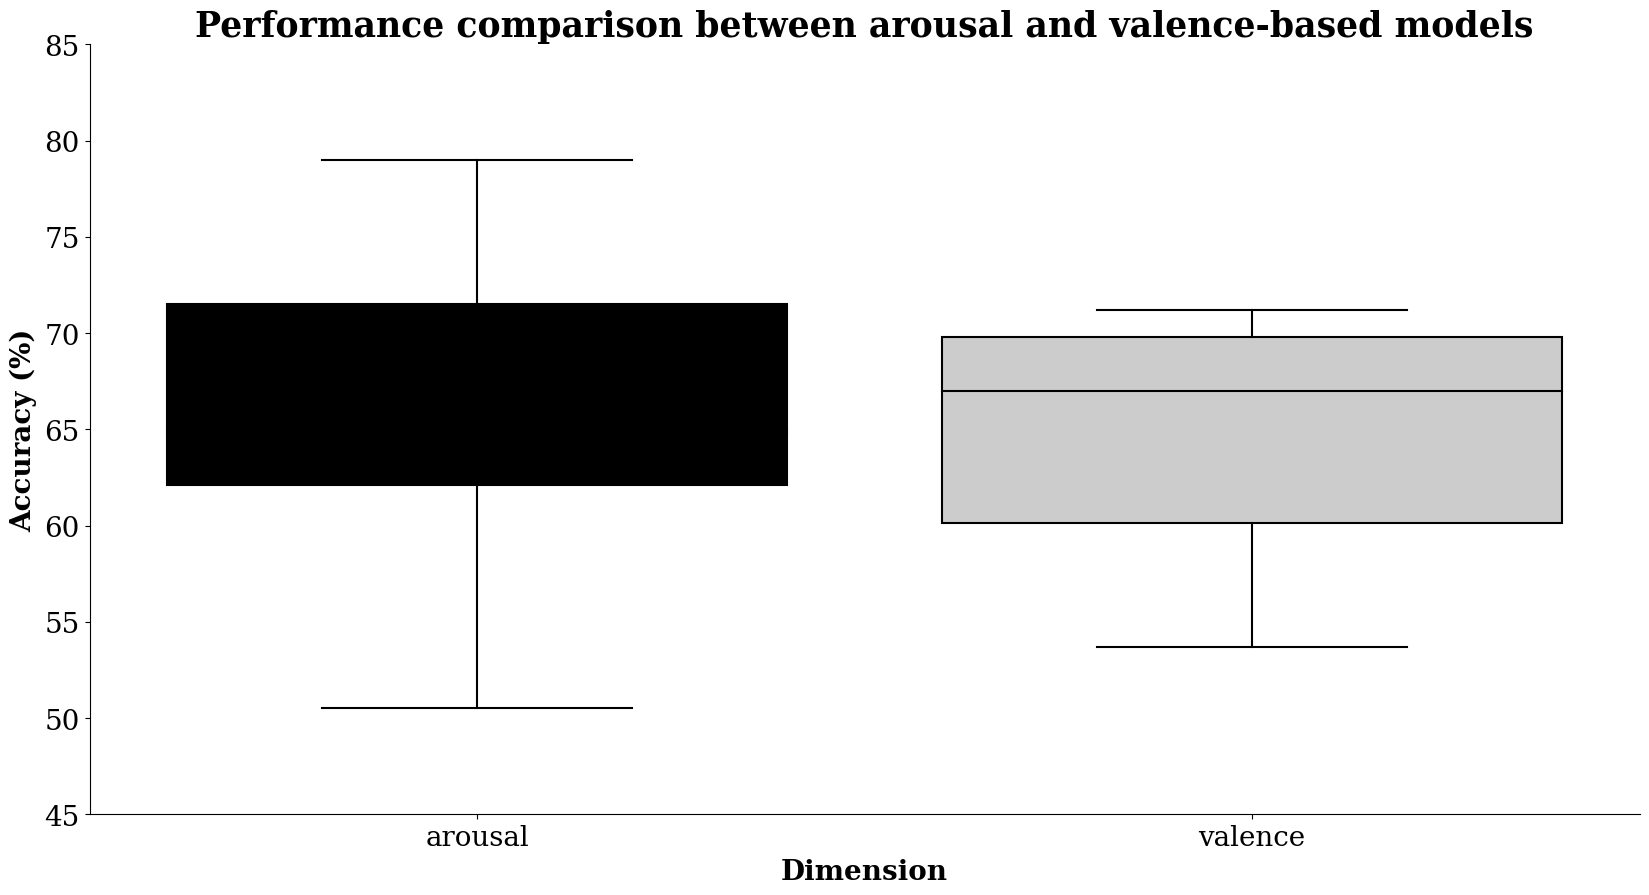

In [67]:
g = sns.boxplot(y="Accuracy (%)", x="Dimension", data=performances_av)
g.set(title = 'Performance comparison between arousal and valence-based models')